In [2]:
import pricer as prc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import streamlit as st

In [16]:

# Liste des tickers à analyser
tickers = ['AAPL', 'MSFT', 'GOOGL']
analyzer = prc.StockAnalyzer(tickers)

volatilities, spot_prices = analyzer.analyze_stocks()

print("Volatilités historiques:")
print(volatilities)
print("\nPrix spot:")
print(spot_prices)

start = datetime(2024, 4, 1)  # Date de début pour la récupération des données
courbe_taux = prc.CourbeTauxAméricaine(start)
taux_actuels = courbe_taux.recuperer_taux()
courbe_taux_simple = courbe_taux.courbe_comme_dict()

# Remplacer votre courbe_taux_exemple par courbe_taux_simple
print(courbe_taux_simple)

# Créer des instances de Maturite et définir la courbe des taux
courbe_taux_exemple = {
    1: 0.01,   # 1.0% pour une maturité de 1 an
    2: 0.015,  # 1.5% pour une maturité de 2 ans
    5: 0.02,   # 2.0% pour une maturité de 5 ans
    10: 0.025, # 2.5% pour une maturité de 10 ans
    15: 0.03   # 3.0% pour une maturité de 15 ans
}
taux = prc.Taux(courbe_taux=courbe_taux_simple, type_interpol="linear")
plt.plot("courbe",taux.__interpol)
# Demande à l'utilisateur
user_input = input("Voulez-vous utiliser les données de marché pour le ticker spécifique (oui/non)?: ").strip().lower()
use_market_data = user_input == "oui"

# Configuration de la simulation
T = 2
nb_steps_par_an = 4
nb_chemins = 1000
modele = "GBM"
symbol = "AAPL"  # Exemple avec Apple
option_infos = prc.OptionInfos(symbol, taux)

# Récupération des données d'options pour toutes les dates d'expiration disponibles
options_data = option_infos.get_all_option_data()
# Tracer la surface de volatilité implicite pour les calls
expirations, strikes, ivs = option_infos.plot_iv_surface(plot_type='calls')


if use_market_data:
        # Utilise les données de marché (prix spot et volatilité implicite)
        S0 = spot_prices[symbol]
        use_iv = True  # Utilise la volatilité implicite
        sigma = None  # La valeur de sigma sera déterminée par la volatilité implicite
else:
        # Utilise des valeurs prédéfinies
        S0 = 100
        sigma = 0.2  # Valeur fixe pour sigma
        use_iv = False  # Ne pas utiliser la volatilité implicite

    
# Simulation avec sigma fixe
simulation = prc.SimulationActif(option_infos, taux, S0, sigma, T, nb_steps_par_an, nb_chemins, modele, use_iv)
prix_simules, taux_simules, discount_factors = simulation.simuler()


# Paramètres spécifiques de l'Autocall
nominal = 1000  # Exemple de nominal
coupon = 0.05  # Exemple de coupon annuel de 5%
barrier_up_initial_factor = 1.1  # Barrière supérieure initiale à 110% de S0
barrier_down_factor = 0.9  # Barrière inférieure finale à 90% de S0
barrier_decrement_factor = 0.01  # Décrément annuel de la barrière supérieure de 2%



# Convertir les résultats en DataFrame
dates = pd.date_range(start=datetime.today(), periods=T * nb_steps_par_an + 1, freq='Q')
df = pd.DataFrame(index=dates)
df['Stock Price'] = prix_simules.mean(axis=0)  # Moyenne sur les chemins simulés
df['Taux'] = taux_simules
df['Discount Factor'] = discount_factors


# Sélectionnez le nombre de chemins à tracer
nb_chemins_a_tracer = nb_chemins
temps = range(prix_simules.shape[1])

plt.figure(figsize=(14, 8))
nb_chemins_a_tracer = min(nb_chemins_a_tracer, prix_simules.shape[0])

# Tracer chaque chemin sélectionné
for i in range(nb_chemins_a_tracer):
    plt.plot(temps, prix_simules[i, :], lw=1, alpha=0.8)

plt.title('Simulation de Monte Carlo de prix d\'actif')
plt.xlabel('Temps')
plt.ylabel('Prix de l\'actif')
plt.grid(True)
plt.show()

# Création et évaluation de l'Autocall
autocall = prc.Autocall(
    prix_simules=prix_simules, 
    discount_factors=discount_factors, 
    S0=S0, 
    nominal=nominal, 
    coupon=coupon, 
    barrier_up_initial_factor=barrier_up_initial_factor, 
    barrier_down_factor=barrier_down_factor, 
    T=T, 
    nb_steps_par_an=nb_steps_par_an, 
    barrier_decrement_factor=barrier_decrement_factor,
    dates=dates
)

# Calcul de l'évolution de la barrière up avant de l'utiliser dans calculer_payoff
evol_barrier_up_off,  evol_barrier_down_off = autocall.evol_barriere()
valeur_autocall, nb_steps, evol_barriere_up, evol_barriere_down, df_probabilite = autocall.calculer_payoff(evol_barrier_up_off, evol_barrier_down_off)

# Ajouter l'évolution de la barrière up et down au DataFrame
df["Barriere UP"] = evol_barriere_up
df["Barriere Down"] = evol_barriere_down
# Commande supplémentaire pour MaJ le df avec activation de la Barriere Down que à la derniere échéance
#df["Barriere Down"].iloc[:-1] = None
# Ajouter la probabilité d'éxécution à chaque échéance
df["Probabilité d'exécution"] = df_probabilite["Probabilité d'exécution"].to_list()
df["Nombre de dépassement"] = df_probabilite["Count_Exceedances"].to_list()

df["Echeance"] = [i for i in range(len(df))]
step = df[df["Stock Price"]>df["Barriere UP"]].Echeance.min()
if step is np.nan:
    step = 0
print(f"Échéances d'autocall (première occurrence ou finale si non autocallé) : {step}")
print(f"Valeur moyenne de l'Autocall: {valeur_autocall}")

    
# Plot le DF - Autocall 
df = df.reset_index()
df = df.rename(columns={'index': 'Date'})
plt.figure(figsize=(14,7))

# Barriere UP
plt.plot(df['Date'], df['Barriere UP'], label='Barriere UP', color='green', marker='o')

# Barriere Down
plt.plot(df['Date'], df['Barriere Down'], label='Barriere Down', color='red', marker='o')

# Stock Price
plt.plot(df['Date'], df['Stock Price'], label='Stock Price', color='blue', marker='o')

# Titles and labels
plt.title('Autocall contract over time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Improve layout and grid visibility
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Volatilités historiques:
{'AAPL': 0.1943361985999806, 'MSFT': 0.2179304909817963, 'GOOGL': 0.2732047165669838}

Prix spot:
{'AAPL': 176.5500030517578, 'MSFT': 421.8999938964844, 'GOOGL': 157.72999572753906}
{1: 0.051699999999999996, 2: 0.0493, 5: 0.0461, 10: 0.045599999999999995, 30: 0.04650000000000001}


AttributeError: 'Taux' object has no attribute '__interpol'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Volatilités historiques:
{'AAPL': 0.1943361985999806, 'MSFT': 0.2179304909817963, 'GOOGL': 0.2732047165669838}

Prix spot:
{'AAPL': 176.5500030517578, 'MSFT': 421.8999938964844, 'GOOGL': 157.72999572753906}
{1: 0.051699999999999996, 2: 0.0493, 5: 0.0461, 10: 0.045599999999999995, 30: 0.04650000000000001}
taux <pricer.Taux object at 0x0000016F78999910>


c:\Users\collo\Documents\Etudes\Dauphine\Produits structurés\Projet\Dauphine_Pricing_Produits_Structur-s\pricer.py:362: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.ticker.history(period="1d")['Close'][0]


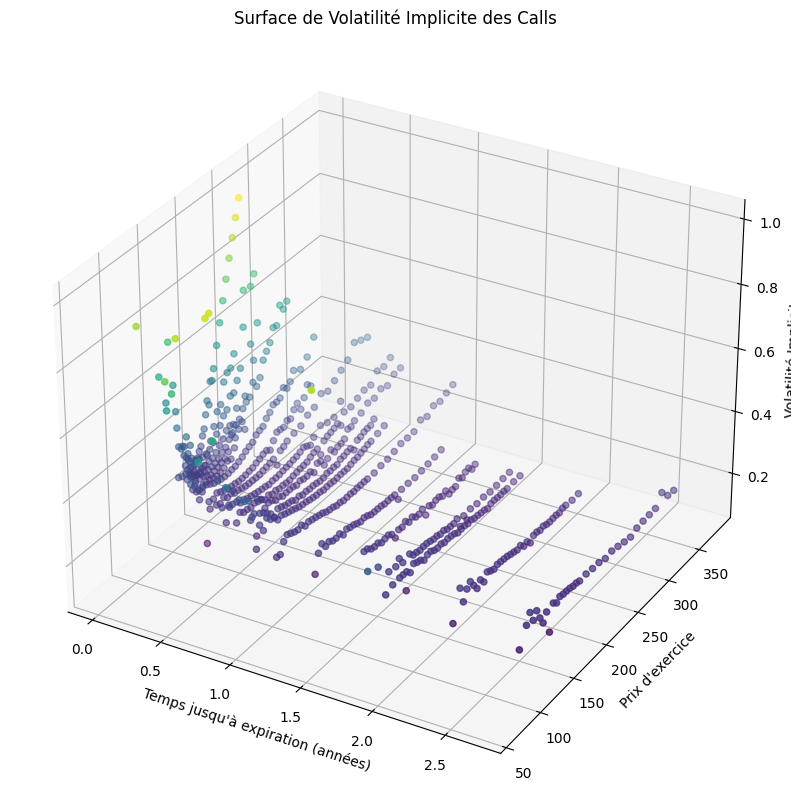

c:\Users\collo\Documents\Etudes\Dauphine\Produits structurés\Projet\Dauphine_Pricing_Produits_Structur-s\pricer.py:362: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.ticker.history(period="1d")['Close'][0]
c:\Users\collo\Documents\Etudes\Dauphine\Produits structurés\Projet\Dauphine_Pricing_Produits_Structur-s\pricer.py:362: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.ticker.history(period="1d")['Close'][0]
c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo)

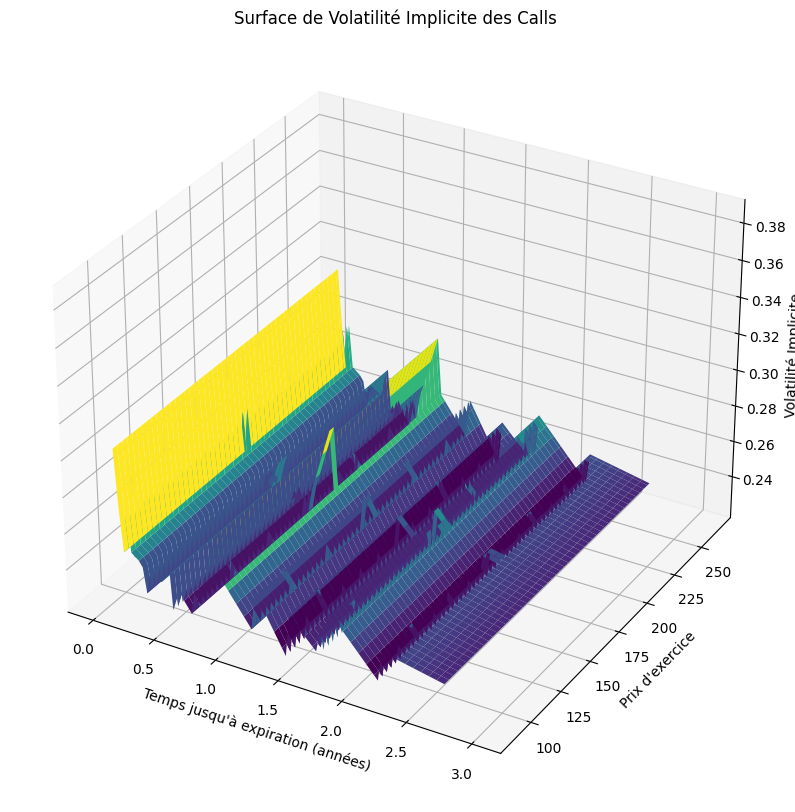

C:\Users\collo\AppData\Local\Temp\ipykernel_20656\667928631.py:59: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start=datetime.today(), periods=T * nb_steps_par_an + 1, freq='Q')


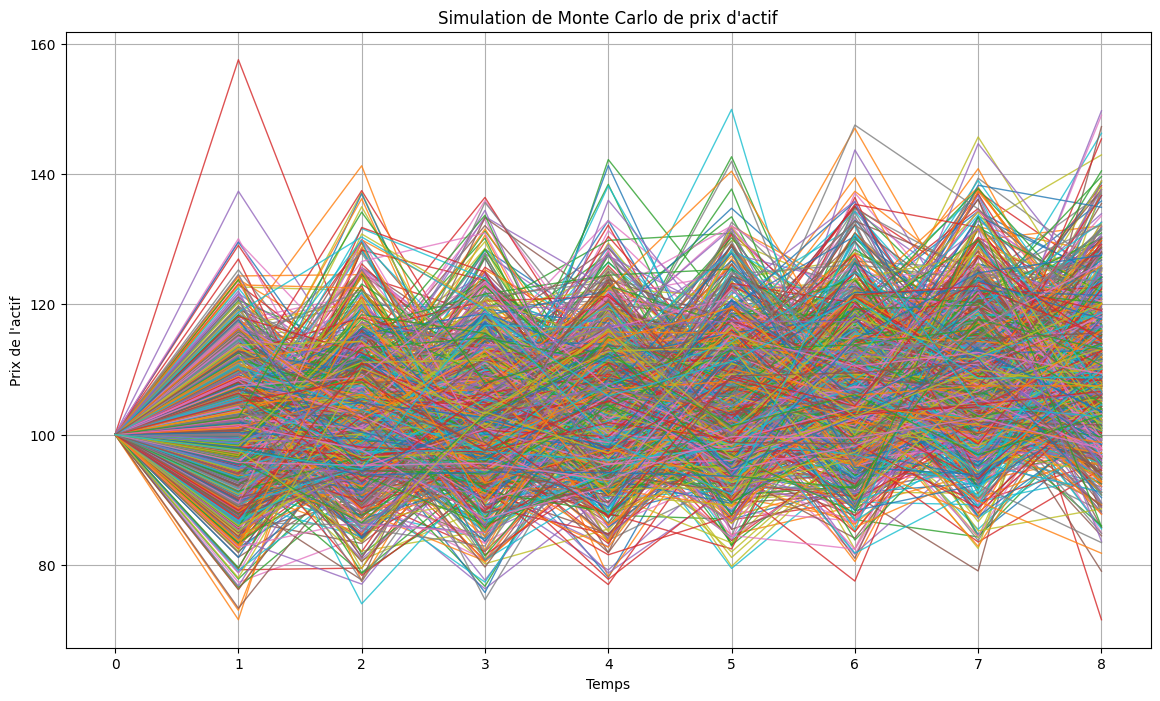

Nombre de coupon: 5





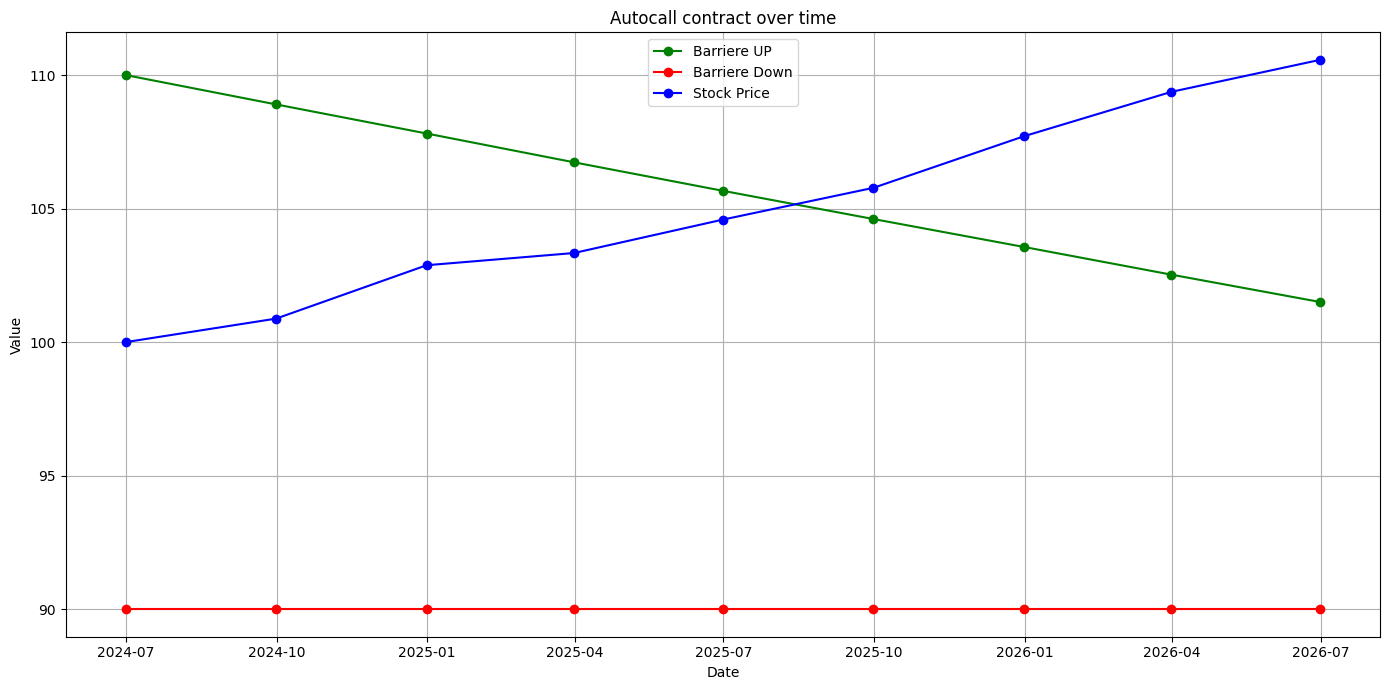

In [14]:
def travaux(tickers,T,nb_steps_par_an, nb_chemins,modele, symbol, nominal, coupon, barrier_up_initial_factor, barrier_down_factor, barrier_decrement_factor,response):
    # Liste des tickers à analyser
    analyzer = prc.StockAnalyzer(tickers)
    volatilities, spot_prices = analyzer.analyze_stocks()

    print("Volatilités historiques:")
    print(volatilities)
    print("\nPrix spot:")
    print(spot_prices)

    start = datetime(2024, 4, 1)  # Date de début pour la récupération des données
    courbe_taux = prc.CourbeTauxAméricaine(start)
    taux_actuels = courbe_taux.recuperer_taux()
    courbe_taux_simple = courbe_taux.courbe_comme_dict()

    # Remplacer votre courbe_taux_exemple par courbe_taux_simple
    print(courbe_taux_simple)

    # Créer des instances de Maturite et définir la courbe des taux
    courbe_taux_exemple = {
        1: 0.01,   # 1.0% pour une maturité de 1 an
        2: 0.015,  # 1.5% pour une maturité de 2 ans
        5: 0.02,   # 2.0% pour une maturité de 5 ans
        10: 0.025, # 2.5% pour une maturité de 10 ans
        15: 0.03   # 3.0% pour une maturité de 15 ans
    }
    taux = prc.Taux(courbe_taux=courbe_taux_simple, type_interpol="linear")
    print("taux",taux.__courbe_taux)
    # Demande à l'utilisateur
    user_input = response.strip().lower()
    use_market_data = user_input == "oui"

    # Configuration de la simulation
    option_infos = prc.OptionInfos(symbol, taux)

    # Récupération des données d'options pour toutes les dates d'expiration disponibles
    options_data = option_infos.get_all_option_data()
    # Tracer la surface de volatilité implicite pour les calls
    expirations, strikes, ivs = option_infos.plot_iv_surface(plot_type='calls')


    if use_market_data:
            # Utilise les données de marché (prix spot et volatilité implicite)
            S0 = spot_prices[symbol]
            use_iv = True  # Utilise la volatilité implicite
            sigma = None  # La valeur de sigma sera déterminée par la volatilité implicite
    else:
            # Utilise des valeurs prédéfinies
            S0 = 100
            sigma = 0.2  # Valeur fixe pour sigma
            use_iv = False  # Ne pas utiliser la volatilité implicite

        
    # Simulation avec sigma fixe
    simulation = prc.SimulationActif(option_infos, taux, S0, sigma, T, nb_steps_par_an, nb_chemins, modele, use_iv)
    prix_simules, taux_simules, discount_factors = simulation.simuler()

    # Convertir les résultats en DataFrame
    dates = pd.date_range(start=datetime.today(), periods=T * nb_steps_par_an + 1, freq='Q')
    df = pd.DataFrame(index=dates)
    df['Stock Price'] = prix_simules.mean(axis=0)  # Moyenne sur les chemins simulés
    df['Taux'] = taux_simules
    df['Discount Factor'] = discount_factors


    # Sélectionnez le nombre de chemins à tracer
    nb_chemins_a_tracer = nb_chemins
    temps = range(prix_simules.shape[1])

    plt.figure(figsize=(14, 8))
    nb_chemins_a_tracer = min(nb_chemins_a_tracer, prix_simules.shape[0])

    # Tracer chaque chemin sélectionné
    for i in range(nb_chemins_a_tracer):
        plt.plot(temps, prix_simules[i, :], lw=1, alpha=0.8)

    plt.title('Simulation de Monte Carlo de prix d\'actif')
    plt.xlabel('Temps')
    plt.ylabel('Prix de l\'actif')
    plt.grid(True)
    plt.show()

    # Création et évaluation de l'Autocall
    autocall = prc.Autocall(
        prix_simules=prix_simules, 
        discount_factors=discount_factors, 
        S0=S0, 
        nominal=nominal, 
        coupon=coupon, 
        barrier_up_initial_factor=barrier_up_initial_factor, 
        barrier_down_factor=barrier_down_factor, 
        T=T, 
        nb_steps_par_an=nb_steps_par_an, 
        barrier_decrement_factor=barrier_decrement_factor,
        dates=dates
    )

    # Calcul de l'évolution de la barrière up avant de l'utiliser dans calculer_payoff
    evol_barrier_up_off,  evol_barrier_down_off = autocall.evol_barriere()
    valeur_autocall, nb_steps, evol_barriere_up, evol_barriere_down, df_probabilite = autocall.calculer_payoff(evol_barrier_up_off, evol_barrier_down_off)

    # Ajouter l'évolution de la barrière up et down au DataFrame
    df["Barriere UP"] = evol_barriere_up
    df["Barriere Down"] = evol_barriere_down
    # Commande supplémentaire pour MaJ le df avec activation de la Barriere Down que à la derniere échéance
    #df["Barriere Down"].iloc[:-1] = None
    # Ajouter la probabilité d'éxécution à chaque échéance
    df["Probabilité d'exécution"] = df_probabilite["Probabilité d'exécution"].to_list()
    df["Nombre de dépassement"] = df_probabilite["Count_Exceedances"].to_list()

    df["Echeance"] = [i for i in range(len(df))]
    step = df[df["Stock Price"]>df["Barriere UP"]].Echeance.min()
    if step is np.nan:
        step = 0
    #print(f"Échéances d'autocall (première occurrence ou finale si non autocallé) : {step}")
    #print(f"Valeur moyenne de l'Autocall: {valeur_autocall}")

        
    # Plot le DF - Autocall 
    df = df.reset_index()
    df = df.rename(columns={'index': 'Date'})
    plt.figure(figsize=(14,7))

    # Barriere UP
    plt.plot(df['Date'], df['Barriere UP'], label='Barriere UP', color='green', marker='o')

    # Barriere Down
    plt.plot(df['Date'], df['Barriere Down'], label='Barriere Down', color='red', marker='o')

    # Stock Price
    plt.plot(df['Date'], df['Stock Price'], label='Stock Price', color='blue', marker='o')

    # Titles and labels
    plt.title('Autocall contract over time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

    # Improve layout and grid visibility
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()


travaux(['AAPL', 'MSFT', 'GOOGL'],2,4,1000,"GBM","AAPL", 1000 ,0.05 ,1.1 , 0.9,0.01,"non")